### 期望计算

$$
\begin{split}
\mathbb E_{x\sim p}[f(x)]=\int p(x)f(x)dx\\
=\int q(x)\frac{p(x)}{q(x)}f(x)dx\\
=\mathbb E_{x\sim q}\left[\frac{p(x)}{q(x)}f(x)\right]
\end{split}
$$

- Importance sampling (IS) is a Monte Carlo technique for the approximation of intractable distributions and integrals with respect to them.
    - 最开始引入 IS 要解决的问题是不好对 $x\sim p(x)$ 直接进行采样，而好对 $x\sim q(x)$ 进行采样（这是我们认为设计和选择的）
    - https://allenwind.github.io/blog/10466/
- 二者均值一样，不代表方差一样；
    - $Var_{x\sim p}[f]=E_{x\sim p}[f^2] - ...$
    - $Var_{x\sim q}[\frac pq f]=E_{x\sim q}\left[\left(\frac{p}{q}f\right)^2\right] - ...=E_{x\sim p}[\frac pq f^2]-...$
    - 如果 $\frac pq$ 差异很大的话，后者的方差就会很大；
- $x\sim q$: sampling
- $w_n=\frac{p(x_n)}{q(x_n)}$: imporance weight
- 在 RL4LLM 的训练中，引入重要性采样，使得 on-policy 的算法（数据利用率较低）可以变得相对地 off-policy
    - 考虑如下的 policy gradient
$$
\begin{split}
&= E_{(s_t, a_t) \sim \pi_\theta} [A^\theta(s_t, a_t) \nabla \log p_\theta(a_t^n | s_t^n)]\\
&= E_{(s_t, a_t) \sim \pi_{\theta'}} \left[ \frac{p_\theta(a_t|s_t)}{p_{\theta'}(a_t|s_t)} A^{\theta'}(s_t, a_t) \nabla \log p_\theta(a_t^n | s_t^n) \right]
\end{split}
$$
    - generate 的样本，可以 update policy 多次；
    - 重要性采样需要大量样本才能做到无偏替代
$$
\mathcal{J}_{PPO}(\theta) = \mathbb{E}_{q \sim P(Q), o \sim \pi_{\theta_{old}}(O|q)} \left[ \frac{1}{|o|} \sum_{t=1}^{|o|} \min \left( \frac{\pi_{\theta}(o_t|q, o_{<t})}{\pi_{\theta_{old}}(o_t|q, o_{<t})} A_t, \text{clip} \left( \frac{\pi_{\theta}(o_t|q, o_{<t})}{\pi_{\theta_{old}}(o_t|q, o_{<t})}, 1-\epsilon, 1+\epsilon \right) A_t \right) \right]
$$


- https://zhuanlan.zhihu.com/p/17657567877
    - 先普及两个 RLHF 算法中的重要参数：rollout_batch_size 和 train_batch_size，前者代表一次性生成多少条训练数据（response 和 reward），后者代表每次用多少条数据来更新模型，前者是后者的 N 倍。
    - 随着训练框架的不断优化， RLHF 的训练数据并没有那么难生产了，尤其是像 OpenRLHF 这种框架，引入了 vllm 来生产 response，效率极高。我们完全可以令 N = 1 / 2 / 4 这种很小的值，且每条训练数据仅使用一次。事实上，由于重要性采样需要大量样本才能做到无偏替代，这个 N 值还真不能很大，越大就越容易训崩。

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, pi, exp
np.random.seed(1234)

In [8]:
mu_p, sigma_p = -0.5, 0.5
def p(x):
    return 1/(sqrt(2*pi)*sigma_p) * exp(-((x - mu_p)**2)/(2*sigma_p**2))

In [10]:
def q(x, mu, sigma):
    return 1/(sqrt(2*pi)*sigma) * exp(-((x - mu)**2)/(2*sigma**2))

def f(x):
    return 1 / (1 + exp(-x)) - 0.5

In [9]:
# Define several different q distributions with varying distances from p
q_params = [
    (0.0, 0.6, "q1: $\mu=0.0, \sigma=0.6$"),   # Closer to p
    (1.5, 0.8, "q2: $\mu=1.5, \sigma=0.8$"),   # Original q
    (2.5, 1.0, "q3: $\mu=2.5, \sigma=1.0$"),   # Further from p
]

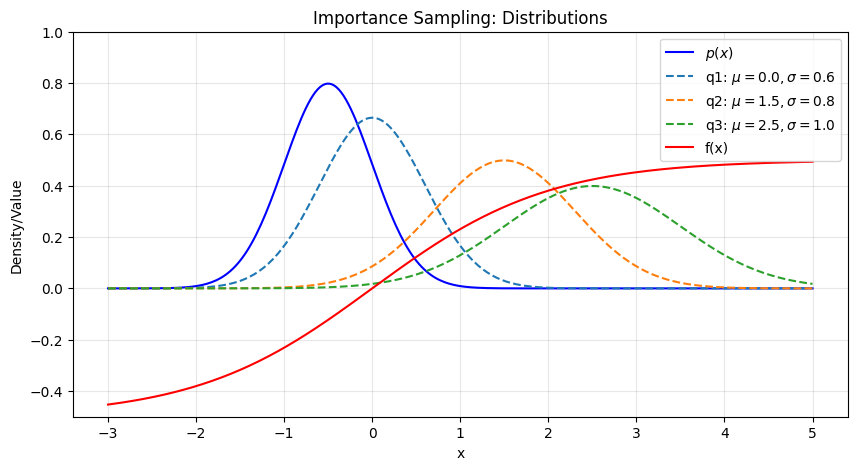

In [12]:
xs = np.linspace(-3, 5, 300)
pxs = [p(x) for x in xs]
fxs = [f(x) for x in xs]

plt.figure(figsize=(10,5))
plt.plot(xs, pxs, label='$p(x)$', color='blue')
for mu, sigma, label in q_params:
    qxs = [q(x, mu, sigma) for x in xs]
    plt.plot(xs, qxs, label=label, linestyle='--')
plt.plot(xs, fxs, label='f(x)', color='red')
plt.ylim(-0.5, 1)
plt.legend()
plt.title('Importance Sampling: Distributions')
plt.xlabel('x')
plt.ylabel('Density/Value')
plt.grid(alpha=0.3)

In [13]:
# Calculate ground truth by direct sampling from p
samples = np.random.normal(loc=mu_p, scale=sigma_p, size=1000000)
mean_fp = np.mean([f(x) for x in samples])
print(f'Ground truth expectation under p(x): {mean_fp:.6f}')

Ground truth expectation under p(x): -0.116002


Distribution q1: $\mu=0.0, \sigma=0.6$, Sample size 10: -0.084525
Distribution q1: $\mu=0.0, \sigma=0.6$, Sample size 100: -0.092245
Distribution q1: $\mu=0.0, \sigma=0.6$, Sample size 1000: -0.113189
Distribution q1: $\mu=0.0, \sigma=0.6$, Sample size 10000: -0.114711
Distribution q1: $\mu=0.0, \sigma=0.6$, Sample size 100000: -0.115185
Distribution q2: $\mu=1.5, \sigma=0.8$, Sample size 10: 0.025215
Distribution q2: $\mu=1.5, \sigma=0.8$, Sample size 100: 0.007397
Distribution q2: $\mu=1.5, \sigma=0.8$, Sample size 1000: -0.083480
Distribution q2: $\mu=1.5, \sigma=0.8$, Sample size 10000: -0.110500
Distribution q2: $\mu=1.5, \sigma=0.8$, Sample size 100000: -0.114701
Distribution q3: $\mu=2.5, \sigma=1.0$, Sample size 10: 0.000679
Distribution q3: $\mu=2.5, \sigma=1.0$, Sample size 100: 0.000508
Distribution q3: $\mu=2.5, \sigma=1.0$, Sample size 1000: -0.019807
Distribution q3: $\mu=2.5, \sigma=1.0$, Sample size 10000: -0.088690
Distribution q3: $\mu=2.5, \sigma=1.0$, Sample size 10

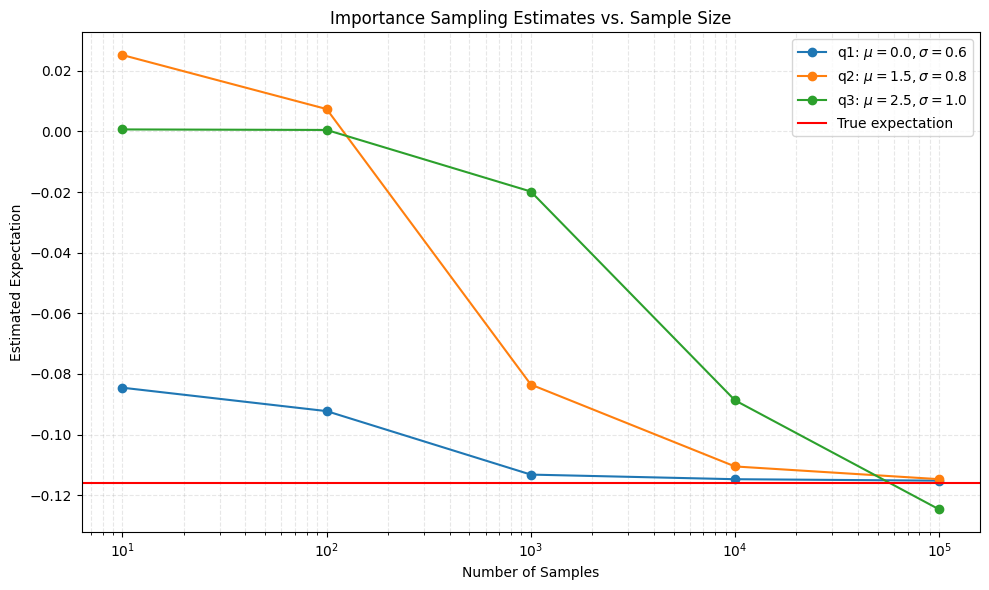

In [15]:
# Importance sampling with varying sample sizes
sample_sizes = [10, 100, 1000, 10000, 100000]
results = {label: [] for _, _, label in q_params}
true_value = mean_fp

plt.figure(figsize=(10,6))
for mu, sigma, label in q_params:
    for size in sample_sizes:
        samples = np.random.normal(loc=mu, scale=sigma, size=size)
        weights = np.array([p(x) / q(x, mu, sigma) for x in samples])
        mean_is = np.mean(weights * np.array([f(x) for x in samples]))
        results[label].append(mean_is)
        print(f"Distribution {label}, Sample size {size}: {mean_is:.6f}")
    
    plt.plot(sample_sizes, results[label], 'o-', label=label)

plt.axhline(y=true_value, color='r', linestyle='-', label='True expectation')
plt.xscale('log')
plt.grid(True, which="both", ls="--", alpha=0.3)
plt.xlabel('Number of Samples')
plt.ylabel('Estimated Expectation')
plt.title('Importance Sampling Estimates vs. Sample Size')
plt.legend()
plt.tight_layout()